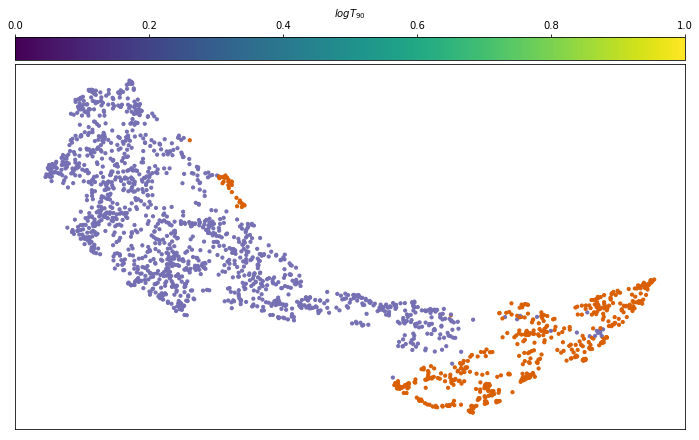

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from ipynb.fs.full.config_BATSE import conf
# This is to prevent a trivial warning pop-up
import warnings
warnings.filterwarnings('ignore')
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Dark2.colors)

emb = pd.read_csv("embedding_UMAP_BATSE.csv", header = None).set_index(0)

fig, ax = plt.subplots(figsize=(12,8))#conf['figsize'])
ax.set(yticks=(), xticks=(), title='UMAP')

emb_plot = ax.scatter(emb[1], emb[2], s=conf['radius'], c=conf['color'][1], cmap=conf['cmap'])

cbar = plt.colorbar(emb_plot, None, ax, label = '$logT_{90}$', location = 'top', aspect = 30, pad = 0.01)



fig.savefig("GRB-UMAP-BATSE.jpg", dpi=300)
fig.show()

In [2]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, MultiChoice, CustomJS, ColumnDataSource, LinearColorMapper, CategoricalColorMapper, ColorBar
from bokeh.layouts import column
from bokeh.palettes import Plasma256
output_notebook()

Loading BokehJS ...

In [3]:
#formatting the data as a CDS
color = conf['color'][0]
try:
    color_mapper = LinearColorMapper(palette=Plasma256, low=min(color), high=max(color))
except:
    color_mapper = CategoricalColorMapper(palette=["mediumpurple", "darkorange"], factors=["tab:purple", "tab:orange"])
source = ColumnDataSource({'names': emb.index.tolist(), 'x': emb[1].tolist(), 'y': emb[2].tolist(), 'color': color})

In [4]:
plot = figure(title='t-SNE projection of the BATSE catalog of GRBs', plot_width=800, plot_height=600, tools="pan,wheel_zoom,box_zoom,lasso_select,reset")
plot.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <span><pre>@names</pre></span>
    </div>
</div>
"""))
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8)
plot.add_layout(color_bar, 'above')
plot.scatter(x = 'x', y = 'y', source = source, color={'field': 'color', 'transform': color_mapper})
multi_choice = MultiChoice(options=emb.index.astype(str).tolist())
update_highlights = CustomJS(args=dict(source=source), code="""
    source.selected['indices'] = []
    for(var i = 0; i < source.get_length(); i++) {
        //console.log(i, source.data['names'][i], cb_obj.value)
        if (cb_obj.value.includes(source.data['names'][i])) {
            source.selected['indices'].push(i)
        }
    }
    source.change.emit()
""")
selected_indices = []
multi_choice.js_on_change('value', update_highlights)
callback = CustomJS(args=dict(source=source), code="""
    //console.log('Running CustomJS callback now.');
    var indices = source.selected.indices;
    var kernel = IPython.notebook.kernel;
    kernel.execute("selected_indices = " + indices)
""")
plot.js_on_event('selectiongeometry', callback)

In [5]:
show(column(multi_choice,plot))

In [12]:
selected = emb.reset_index().isin(emb.iloc[list(selected_indices)].index)[0].replace({False: 'L', True: 'S'})
df = pd.concat([pd.Series(emb.index), selected], axis = 1, ignore_index = True).rename({0: 'GRBname', 1: 'type'}, axis=1).set_index('GRBname')
print(df.loc[df.type=='S'])
print(df.loc[df.type=='L'])
print(len(df))
#df.to_csv('DataFrames/classification_BATSE_UMAP.txt')

        type
GRBname     
1025       S
1051       S
1073       S
1076       S
1088       S
...      ...
867        S
906        S
909        S
936        S
999        S

[484 rows x 1 columns]
        type
GRBname     
1009       L
1036       L
1039       L
1042       L
1046       L
...      ...
938        L
942        L
946        L
973        L
974        L

[1427 rows x 1 columns]
1911


Text(0.5, 0, 'log$T_{90}$')

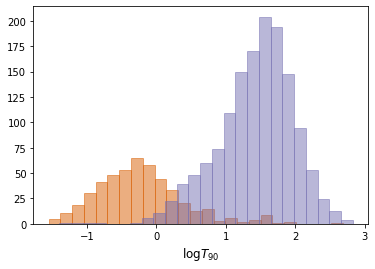

In [9]:
duration_data = pd.read_pickle('DataFrames/duration_data_BATSE.dat')
group = df.groupby(df.type)
short = group.get_group('S').index
long = group.get_group('L').index
plt.hist(np.log10(duration_data.loc[short,'T90']), bins = 25, color = 'C1', edgecolor = 'C1', alpha = 0.5)
plt.hist(np.log10(duration_data.loc[long,'T90']), bins = 25, color = 'C2', edgecolor = 'C2', alpha = 0.5)
plt.xlabel('log$T_{90}$', size = 12)